# Fluid substitution using Gassmann
Necessary imports

In [12]:
import matplotlib.pyplot as plt
import os
import utils.io as uio
from core.well import Project, Well
from core.minerals import MineralMix
from core.fluids import FluidMix
import rp.rp_core as rp
import plotting.plot_rp as prp

## Create a project
The project remembers where important information is stored, and controls the logging. More details about how to set up a project is found in *Introduction to blixt_rp.ipnb*.

In [2]:
wp = Project(
    name='FluidSub', 
    project_table='excels/project_table.xlsx')

Note that relative path names are allowed. The project table is a .xlsx file that contain which wells and well logs to load, where to find them, and important for fluid substitution; the fluids and minerals.

### Load wells
The *Wells table* sheet of the *project_table.xlsx* holds information about which wells and well logs to use.
<img src="images/Fluid substitution - wells.png" />
In this case, we only read in Well F, and the selected well logs that the las file *test_data/Well F.las* contains.

Wells are loaded using:

In [3]:
wells= wp.load_all_wells(block_name='FBlock')
w = wells['WELL_F']

0 WELL_F test_data/Well F.las


The *block_name* key word is used to group the logs of *Well F*, but is not necessary to specify.

### Load working intervals and templates
The working intervals are used to define where the fluid substitution will take place, and the templates are useful for extracting kelley bushing and water depth (from the *Well settings* sheet) if they're not present in the well logs. These are loaded through:

In [4]:
wis = uio.project_working_intervals(wp.project_table)
templates = uio.project_templates(wp.project_table)

### Load fluids
The *Fluids* sheet of the *project_table.xlsx* holds information about the fluids that our fluid mixtures contains.
<img src="images/Fluid substitution - fluids.png" />

Column *A* to *D* contains name, bulk and shear modolus, and density (if column *E* is set to *User specified*). 
The name of a fluid must be unique.
If column *I*, Pressure reference, is set to zero, the reference pressure at the seafloor, the mudline, is calculated in the fluid substitution, based on the seawater column.

The *Fluid mixtures* sheet uses the fluids defined above to determine how they are used in fluid substitution. 
To complete a fluid substitution, it is necessary to have defined an initial and final fluid(s) for the specific well, and for the specific working interval. If you want to run fluid substitution in other wells, and/or other working intervals, in the same run, just add similar lines specifying the fluids.

<img src="images/Fluid substitution - fluidmixs.png" />

- *Column A*: **Use** 
 - The first column determines if the fluid is be included in a substitution or not
- *Column B*: **Substitution order** 
 - The second column determines if the fluid belongs to the *Initial* or *Final* fluids.
- *Column C*: **Well name**
 - Is the name of well, as defined in the *Wells table* sheet, this fluid is used in.  
- *Column D*: **Interval name**
 - name of the working interval this fluid is used
- *Column E*: **Fluid name**
 - The selected fluid, from *Fluids* sheet.
- *Column F*: **Fluid type**
 - Select if the fluid is a Brine, Gas or Oil. This will only have any meaning if the *Calculation method* of the fluid definition (*Fluids* sheet) is set to *Batzle and Wang*.
- *Column G*: **Volume fraction**
 - Column *G* determines which Volume fraction (saturation) to use for the fluid. Set it to the name of a well log (*SW* for the final Brine saturation in this example), or *complement* if the fluids takes up the remaining volume, or a number if a constant saturation is requested. If there are two or more fluids present in an intial or final fluid mix, one has to be set to *complement*.

Load the fluids through

In [5]:
myfluids = FluidMix() 
myfluids.read_excel(wp.project_table)
print(myfluids.print_all_fluids())

Fluid mixture: initial, WELL_F, SAND E, MyFluids
  brine_
      K: 2.68, Mu: nan, Rho 1.023
      Calculation method: User specified
      Status: from excel
      Volume fraction: 1.0
Fluid mixture: final, WELL_F, SAND E, MyFluids
  default_oil
      K: nan, Mu: nan, Rho nan
      Calculation method: Batzle and Wang
      Status: from excel
      Volume fraction: complement
  default_brine
      K: nan, Mu: nan, Rho nan
      Calculation method: Batzle and Wang
      Status: from excel
      Volume fraction: sw



Notice that the elastic properties are all *nan* (not a number) for the *final* fluids. This is because the *Calculation method* is set to *Batzle and Wang*, and the calculation of the elastic properties of the fluids will be done later in the actual fluid substitution.

The initial *Brine* (*brine_*) is *User specified*, and takes the values directly from the excel sheet.

### Load minerals
Similarly to the fluids, the *Minerals* sheet of the *project_table.xlsx* holds information about the minerals used in the calculation of the mineral bulk modulus
<img src="images/Fluid substitution - Minerals.png" />
Column *A* to *D* contains name, bulk and shear modolus, and density of minerals. 
Column *F* can be set to *Interval average* or *User specified*, empty cells are interpreted as *User specified*. 
When set to *Interval average* it uses the cutoff defined in column *G* to calculate the mineral properties for each well and working interval the minerals is used. The lognames specified in column *G*, i.e. *VCL* and *PHIE* must exist in the wells that are used for fluid substitution.

The *Mineral mixtures* sheet 
<img src="images/Fluid substitution - Mineralmixs.png" />

holds information about which minerals are present in individual intervals for each well, and their volume distribution.
Similar to the fluids above. 
Column *F* determines which Volume fraction (saturation) to use for the minerals. Set it to the name of a well log (*VCL* for the Shale in this example), or *complement* if the mineral takes up the remaining volume, or a number if a constant volume fraction is requested. 

Minerals for which no *Volume fraction* is specified are ignored by the system.

**Note** that for a fluid substitution to run successfully, the fluid mixture and minral mixtures have to be properly set up for the same wells and working intervals in both *Fluid mixtures* and *Mineral mixtures* sheets.

Load the minerals through

In [6]:
mymins = MineralMix() 
mymins.read_excel(wp.project_table)
print(mymins.print_all_minerals())

Mineral mixture: WELL_F, SAND E, MyMinerals
    quartz
      K: 36.6, Mu: 45.0, Rho 2.65
      Calculation method: User specified, cutoff: None
      Status: from excel
      Volume fraction: complement
    shale
      K: 11.4, Mu: 3.0, Rho 2.35
      Calculation method: Interval average, cutoff: VCL>0.8, PHIE<0.1
      Status: from excel
      Volume fraction: vcl



The *Shale* has the values for *K*, *Mu*, and *Rho* taken directly from the excel sheet, although we have specified it to be calculated as an *Interval average*. The calculation of the interval average will be done later in the actual fluid substitution, and the excel values are used as default values if the average calculation fails.

## Fluid substitution
Cut-offs are used to define sands, and we will restrict the fluid substitution to these

In [7]:
cutoffs = {'Volume': ['<', 0.5], 'Porosity': ['>', 0.1]}

We also need to specify which logs we would use as inputs to the fluid substitution

In [8]:
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vsh'}

The rest of the work (calculating initial and final fluid properties, mineral properties, etc.), and the gassmann fluid substitution, is handled by the following function

In [9]:
tag = 'fs'  # tag the resulting logs after fluid substitution
rp.run_fluid_sub(wells, log_table, mymins, myfluids, cutoffs, wis, tag, templates=templates, block_name='FBlock')

INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract water depth in well WELL_F from templates
INFO: Extract Kelly bushing in well WELL_F using key: edf, with value 24.00 [m].
INFO: Extract water depth in well WELL_F from templates
INFO: Extract Kelly bushing in well WELL_F using key: edf, with value 24.00 [m].
INFO: Starting Gassmann fluid substitution on well WELL_F
Calculating Voigt-Reuss-Hill bound of k for well WELL_F in interval SAND E
  quartz    K: 36.6, Mu: 45.0, Rho 2.65
    Volume fraction: complement
  shale    K: 22.337340368891446, Mu: 11.096107785059152, Rho 2.5890000000000004
    Volume fraction: vcl

 Mineral k: quartz, volume frac: complement
 Mineral k: shale, volume frac: vcl
Calculating Voigt bound of rho for well WELL_F in interval SAND E
  brine_    K: 2.68, Mu: nan, Rho 1.023
    Volume fraction: 1.0

 Fluid rho: brine_, volume frac: 1

C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:551: RuntimeWarning: invalid value encountered in greater
  if (abs(sum(f) - 1.0) > 0.02).any():
C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:705: RuntimeWarning: invalid value encountered in less
  por[por < 7E-3] = 7E-3
C:\Users\mblixt\PycharmProjects\blixt_rp\rp\rp_core.py:724: RuntimeWarning: invalid value encountered in sqrt
  v_p_2 = np.sqrt((k_2+(4/3)*mu_2) / rho_2) * 1E3  # m/s


### Plotting the results
First plot the original input logs, then replot using the newly created fluid substituted logs, and then replot again using the loaded example from an earlier fluid substitution results (from RokDoc) that was saved to the las file. 

Plotting well WELL_F
Plotting well WELL_F
Plotting well WELL_F


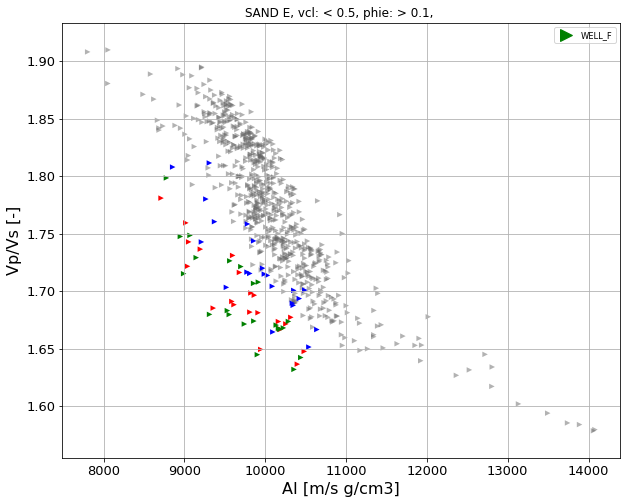

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
log_table = {'P velocity': 'vp_dry', 'S velocity': 'vs_dry', 'Density': 'rho_dry', 'Porosity': 'phie', 'Volume': 'vsh'}
templates['WELL_F']['color'] = 'b'
prp.plot_rp(wells, log_table, wis, 'SAND E', cutoffs, templates, fig=fig, ax=ax, edge_color=False, show_masked=True, block_name='FBlock')

# specify the new logs coming from the fluid substitution
log_table = {'P velocity': 'vp_dry_fs', 'S velocity': 'vs_dry_fs', 'Density': 'rho_dry_fs', 'Porosity': 'phie', 'Volume': 'vsh'}
templates['WELL_F']['color'] = 'r'
prp.plot_rp(wells, log_table, wis, 'SAND E', cutoffs, templates, fig=fig, ax=ax, edge_color=False, block_name='FBlock')

# specify the new logs coming from the RokDoc fluid substitution stored in the las file
log_table = {'P velocity': 'vp_so08', 'S velocity': 'vs_so08', 'Density': 'rho_so08', 'Porosity': 'phie', 'Volume': 'vsh'}
templates['WELL_F']['color'] = 'g'
prp.plot_rp(wells, log_table, wis, 'SAND E', cutoffs, templates, fig=fig, ax=ax, edge_color=False, block_name='FBlock')

The grayed out points are the shales within *SAND E* working interval, and the blue markers are the initial values.
Red markers are the current fluid substitution, while the green are from an earlier fluidsubstitution in RokDoc. As can be seen does the current fluid substitution produce similar results as RocDoc.

### Saving the results
Save the well as a las file

In [14]:
for well in wells.values():
    uio.write_las(
        os.path.join(wp.working_dir, 'results_folder', '{}.las'.format(well.well)),
        well.header,
        well.block['FBlock'].header,
        well.block['FBlock'].logs
    )

In [15]:
w.block['FBlock'].logs['vp_dry_fs'].header

                name: vp_dry_fs
                well: WELL_F
       creation_info: Created by mblixt, at NO-OSVM-WKS153, on 2020-05-26T10:18:30.348939, using version 0.1.1
       creation_date: 2020-05-26T10:18:30.348939
       orig_filename: test_data/Well F.las
   modification_date: 2020-05-26T10:18:42.320910
modification_history: Calculated using Gassmann fluid substitution using following
Mineral mixtures: Mineral mixture: WELL_F, SAND E, MyMinerals
    quartz
      K: 36.6, Mu: 45.0, Rho 2.65
      Calculation method: User specified, cutoff: None
      Status: from excel
      Volume fraction: complement
    shale
      K: 22.337340368891446, Mu: 11.096107785059152, Rho 2.5890000000000004
      Calculation method: Interval average, cutoff: VCL>0.8, PHIE<0.1
      Status: calculated from interval average
      Volume fraction: vcl

Initial fluids: Fluid mixture: initial, WELL_F, SAND E, MyFluids
  brine_
      K: 2.68, Mu: nan, Rho 1.023
      Calculation method: User specified
   